In [4]:
import requests
import time

coin_id = "bitcoin"
url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range"

to_ts = int(time.time())                 
from_ts = to_ts - 90 * 24 * 60 * 60    

params = {    
    "vs_currency": "usd",
    "from": from_ts,
    "to": to_ts        
}

response = requests.get(url, params=params)
data = response.json()

print(data)

{'prices': [[1754676269600, 116666.67964128975], [1754679854221, 116506.94482165811], [1754683440556, 116449.75033943536], [1754687378840, 116834.12792892547], [1754690572050, 116951.43064524583], [1754694357409, 116895.02084894278], [1754698007589, 116686.72473635004], [1754701768000, 116611.67486663083], [1754705345258, 116566.64327820552], [1754708662156, 116441.19539824275], [1754712236094, 116397.67926922366], [1754716145226, 116423.53362042307], [1754719783458, 116708.22561872333], [1754723086588, 116653.89502137293], [1754726995122, 116768.27206611432], [1754730579954, 117077.76520803696], [1754734272754, 117533.0938367717], [1754737463919, 117441.67571151303], [1754741371285, 117108.46189936704], [1754744495758, 117097.50306534256], [1754748057348, 116996.92141091316], [1754751863441, 116965.931269068], [1754755470776, 116845.40417692252], [1754759007918, 116667.73371007525], [1754762940518, 116660.84198406573], [1754766516104, 116647.05734217919], [1754770170112, 116541.075842

In [ ]:
import pandas as pd
import numpy as np

def _to_df(series, value_name):
    df = pd.DataFrame(series, columns=["ts_ms", value_name])
    df["date_utc"] = pd.to_datetime(df["ts_ms"], unit="ms", utc=True)
    df = df.drop(columns=["ts_ms"]).sort_values("date_utc")
    df[value_name] = pd.to_numeric(df[value_name], errors="coerce").replace(0, np.nan)
    return df

def coingecko_to_daily_ohlcv(data_json):
    # Intraday price & volume frames
    prices_df = _to_df(data_json["prices"], "price")
    vols_df   = _to_df(data_json["total_volumes"], "vol_ccy")  # currency volume 

    # Align by nearest timestamp 
    tick = pd.merge_asof(
        prices_df.sort_values("date_utc"),
        vols_df.sort_values("date_utc"),
        on="date_utc",
        direction="nearest",
        tolerance=pd.Timedelta("5min"),
    )

    # cleanup
    tick["price"] = tick["price"].ffill(limit=3)
    tick = tick.dropna(subset=["price", "vol_ccy"]).set_index("date_utc").sort_index()

    # Approximate BTC volume = currency_volume / price
    tick["vol_btc"] = tick["vol_ccy"] / tick["price"]

    # Resample to daily
    ohlc = tick["price"].resample("1D").agg(
        Open="first",
        High="max",
        Low="min",
        Close="last"
    )

    vols = tick.resample("1D").agg(
        **{
            "Volume (BTC)": ("vol_btc", "sum"),
            "Volume (Currency)": ("vol_ccy", "sum"),
        }
    )

    daily = pd.concat([ohlc, vols], axis=1)
    daily.index.name = "Date"
    daily = daily.dropna(how="all")
    return daily

btc_daily = coingecko_to_daily_ohlcv(data)
btc_daily.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency)
Date,,,,,,
2025-08-08 00:00:00+00:00,116666.679641,116951.430645,116449.750339,116895.020849,1.779428e+06,2.076796e+11
2025-08-09 00:00:00+00:00,116686.724736,117533.093837,116397.679269,116566.514615,6.045464e+06,7.060384e+11
2025-08-10 00:00:00+00:00,116500.754612,119034.739530,116500.754612,119034.739530,6.661556e+06,7.874818e+11
2025-08-11 00:00:00+00:00,119248.448278,122227.469335,118589.492799,118817.456362,1.023323e+07,1.230629e+12
2025-08-12 00:00:00+00:00,118726.760976,120016.483177,118378.159359,119999.157380,9.967583e+06,1.187360e+12


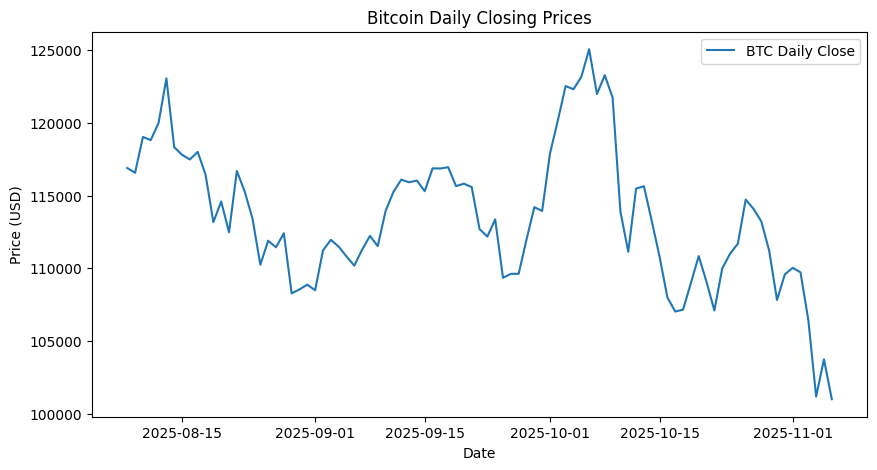

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(btc_daily.index, btc_daily["Close"], label="BTC Daily Close")
plt.title("Bitcoin Daily Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [7]:
import numpy as np 
import math

# Sharp Ratio Grading Thresholds:
# Less than 1: Bad
# 1 – 1.99: Adequate/good
# 2 – 2.99: Very good
# Greater than 3: Excellent

# prices: array of prices
# rf: risk-free rate of return
def risk_return(prices, rf=0.04):
    returns = [((prices[i] - prices[i-1]) / prices[i-1]) for i in range(1, len(prices))]
    risk = np.std(returns)
    reward = np.mean(returns)
    return reward - rf / risk

print(risk_return(btc_daily["BTC"]))

# over 90 days
def volatility(prices):
    returns = [((prices[i] - prices[i-1]) / prices[i-1]) for i in range(1, len(prices))]
    average = sum(returns) / len(returns)
    diffs = []
    for daily_return in returns:
        diffs.append((daily_return - average)**2)
    sd = [math.sqrt(diff/len(returns)) for diff in diffs]
    crypto_volatility = [round(n * math.sqrt(365) * 100, 2) for n in sd]
    return crypto_volatility

btc_volatility = volatility(btc_daily["BTC"])
print(btc_volatility)



KeyError: 'BTC'

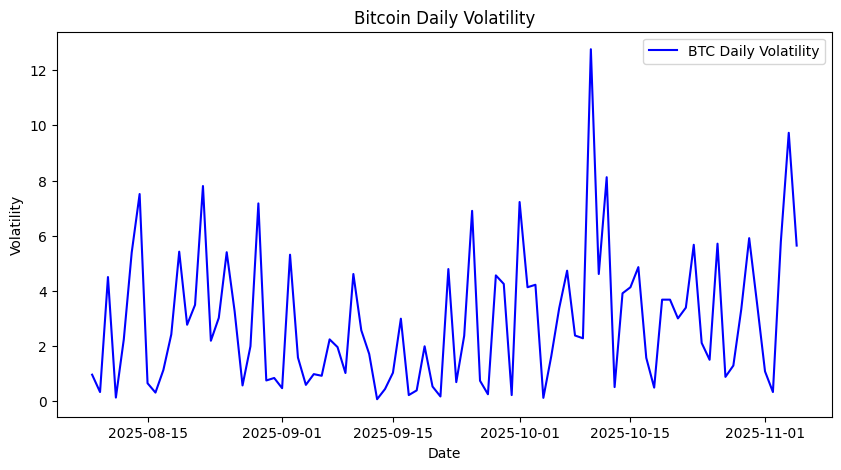

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(btc_daily["date"][1:], btc_volatility, color="blue", label="BTC Daily Volatility")
plt.title("Bitcoin Daily Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()
